## Import

In [17]:
import random
import pandas as pd
import numpy as np
import os

from sklearn.ensemble import RandomForestRegressor
data_path = 'C:\Workspace/power_consumption_comp\data'
import warnings
warnings.filterwarnings(action='ignore')    

## Fixed Random-Seed
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Train Data Pre-Processing

In [ ]:
train_df = train_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_df = test_df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)
building_info.drop('Unnamed: 0', axis = 1 , inplace=True)


In [98]:
## Load Data
train_df = pd.read_csv('C:\Workspace/power_consumption_comp\data/train.csv')
test_df = pd.read_csv('C:\Workspace/power_consumption_comp\data/test.csv')
building_info  = pd.read_csv('C:\Workspace/power_consumption_comp\data/building_info.csv')
    

#데이터를 building_info와 합치기 및 전처리
def preprocessing(df,merge=True):
    #결측값을 0으로 채웁니다 안바꿔도 됨
    df = df.fillna(0)
    #시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
    df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')
    #람다식을 이용해 일시에서 달,일,시간을 잘라낸것
    df['month'] = df['일시'].dt.month
    df['day'] = df['일시'].dt.day
    df['time'] = df['일시'].dt.hour
    if merge:
        # 'building_number'를 기준으로 두 데이터프레임 병합 및 전처리
        merged_df = pd.merge(df, building_info, on='건물번호',how='right')
        merged_df['태양광용량(kW)'] = merged_df['태양광용량(kW)'].replace('-', 0)
        merged_df['ESS저장용량(kWh)'] = merged_df['ESS저장용량(kWh)'].replace('-', 0)
        merged_df['PCS용량(kW)'] = merged_df['PCS용량(kW)'].replace('-', 0)

        merged_df['태양광용량(kW)'] = merged_df['태양광용량(kW)'].astype('float64')
        merged_df['ESS저장용량(kWh)'] = merged_df['ESS저장용량(kWh)'].astype('float64')
        merged_df['PCS용량(kW)'] = merged_df['PCS용량(kW)'].astype('float64')
        
        
        merged_df =  merged_df.drop(columns=['num_date_time', '일시','건물번호','냉방면적(m2)'])
        return merged_df
        
    
    merged_df =  merged_df.drop(columns=['num_date_time', '일시','건물번호'])
    return merged_df    
    #merged_df.info()




In [87]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

merged_df = preprocessing(train_df)


items = merged_df['건물유형']   
# 2차원 ndarray로 변환합니다. 
items = np.array(items).reshape(-1, 1)
# 원-핫 인코딩을 적용합니다. 
oh_encoder = OneHotEncoder()
oh_encoder.fit(items)    
oh_labels = oh_encoder.transform(items)

# OneHotEncoder로 변환한 결과는 희소행렬이므로 toarray()를 이용해 밀집 행렬로 변환. 
oh_labels = oh_labels.toarray()
print('원-핫 인코딩 데이터 차원')
print(oh_labels.shape)  
print(oh_labels.dtype)  

oh_labels = pd.DataFrame(oh_labels)
oh_labels.astype('Int64')
merged_df = pd.concat([merged_df, oh_labels],axis=1)


merged_df = merged_df.drop(columns=['건물유형'])
merged_df.columns = merged_df.columns.astype(str)
merged_df.head()


원-핫 인코딩 데이터 차원
(204000, 12)
float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   기온(C)         204000 non-null  float64
 1   강수량(mm)       204000 non-null  float64
 2   풍속(m/s)       204000 non-null  float64
 3   습도(%)         204000 non-null  float64
 4   일조(hr)        204000 non-null  float64
 5   일사(MJ/m2)     204000 non-null  float64
 6   전력소비량(kWh)    204000 non-null  float64
 7   month         204000 non-null  int32  
 8   day           204000 non-null  int32  
 9   time          204000 non-null  int32  
 10  연면적(m2)       204000 non-null  float64
 11  태양광용량(kW)     204000 non-null  float64
 12  ESS저장용량(kWh)  204000 non-null  float64
 13  PCS용량(kW)     204000 non-null  float64
 14  0             204000 non-null  float64
 15  1             204000 non-null  float64
 16  2             204000 non-null  float64
 17  3           

,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),month,day,time,...,2,3,4,5,6,7,8,9,10,11
0,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,6,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17.7,0.0,1.5,45.0,0.0,0.0,974.88,6,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.7,0.0,1.4,48.0,0.0,0.0,953.76,6,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.4,0.0,2.8,43.0,0.0,0.0,986.40,6,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:





def one_hot_encoding(df):
    
    items = df['건물유형']   
    
    # 2차원 ndarray로 변환합니다. 
    items = np.array(items).reshape(-1, 1)
    # 원-핫 인코딩을 적용합니다. 
    oh_encoder = OneHotEncoder()
    oh_encoder.fit(items)    
    oh_labels = oh_encoder.transform(items)

    # OneHotEncoder로 변환한 결과는 희소행렬이므로 toarray()를 이용해 밀집 행렬로 변환. 
    oh_labels = oh_labels.toarray()
    print('원-핫 인코딩 데이터 차원')
    print(oh_labels.shape)  
    print(oh_labels.dtype)  

    oh_labels = pd.DataFrame(oh_labels)
    oh_labels.astype('Int64')
    df = pd.concat([df, oh_labels],axis=1)


    df = df.drop(columns=['건물유형'])
    df.columns = df.columns.astype(str)
    
    return df


merged_df = preprocessing(merged_df)
merged_df = one_hot_encoding(merged_df)
merged_test_df = preprocessing(merged_test_df)
merged_test_df = one_hot_encoding(merged_test_df)

KeyError: '일시'

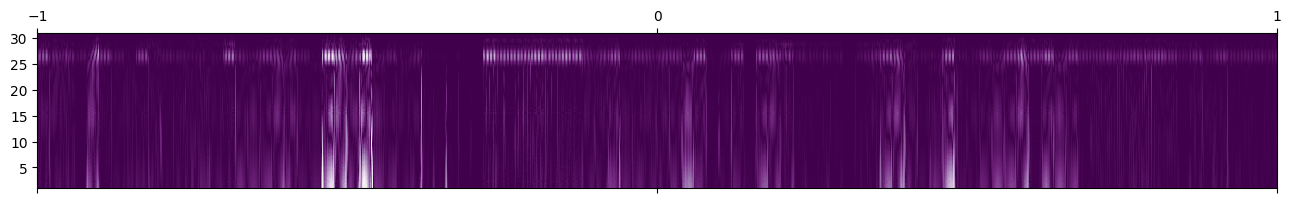

In [92]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# 전력 사용량 데이터를 numpy 배열로 변환
# 이 예제에서는 임의의 데이터를 사용합니다.
power_usage = merged_df['전력소비량(kWh)'].to_numpy(dtype="float64")


# Morlet 웨이블릿 객체 생성
wavelet = pywt.ContinuousWavelet('morl')

# 연속 웨이블릿 변환 수행
scales = np.arange(1, 128)
[cfs, frequencies] = pywt.cwt(power_usage, scales, wavelet, 1.0)

# 변환 결과 시각화
plt.matshow(np.abs(cfs), aspect='auto', cmap='PRGn', extent=[-1, 1, 1, 31])
plt.show()


In [ ]:
# 병합된 데이터프레임의 상관계수 계산
# 데이터프레임 생성

corr_df = pd.DataFrame({
    '전소_연면적': [merged_df['전력소비량(kWh)'].corr(merged_df['연면적(m2)'])], 
    '전소_냉방면적': [merged_df['전력소비량(kWh)'].corr(merged_df['냉방면적(m2)'])], 
    '전소_태양광용량': [merged_df['전력소비량(kWh)'].corr(merged_df['태양광용량(kW)'])],
    '전소_ESS저장용량': [merged_df['전력소비량(kWh)'].corr(merged_df['ESS저장용량(kWh)'])],
    '전소_PCS용량': [merged_df['전력소비량(kWh)'].corr(merged_df['PCS용량(kW)'])],
    '전소_일조': [merged_df['전력소비량(kWh)'].corr(merged_df['일조(hr)'])],
    '전소_일사': [merged_df['전력소비량(kWh)'].corr(merged_df['일사(MJ/m2)'])],
    '전소_기온': [merged_df['전력소비량(kWh)'].corr(merged_df['기온(C)'])],
    '전소_습도': [merged_df['전력소비량(kWh)'].corr(merged_df['습도(%)'])],
    '전소_풍량': [merged_df['전력소비량(kWh)'].corr(merged_df['풍속(m/s)'])],
    '전소_강수량': [merged_df['전력소비량(kWh)'].corr(merged_df['강수량(mm)'])],
    '일사_기온': [merged_df['기온(C)'].corr(merged_df['일사(MJ/m2)'])],
    '일사_습도': [merged_df['습도(%)'].corr(merged_df['일사(MJ/m2)'])],
    '일사_풍속': [merged_df['풍속(m/s)'].corr(merged_df['일사(MJ/m2)'])],
    
    })

# 상관계수 행렬 출력
corr_df

In [71]:
#데이터와 label분리를 위한 함수
label_list = ['전력소비량(kWh)','일조(hr)','일사(MJ/m2)']
def make_labels(df, level = 0, best_parameter = False, scale = 576):
    
    #하이퍼 파라미터 튜닝 할때만 작동함
    if best_parameter:
        df = df[0:scale][:]
    #데이터와 label분리
    
    if level == 1:
        train_y = df['전력소비량(kWh)']
        train_x = df.drop(columns=['전력소비량(kWh)'])
        return train_x,train_y
    if level == 2:
        train_y = df['일조(hr)']
        train_x = df.drop(columns=['전력소비량(kWh)','일조(hr)'])
        return train_x.sort_index(axis=1),train_y
    if level == 3:
        train_y = df['일사(MJ/m2)']
        train_x = df.drop(columns=['전력소비량(kWh)','일조(hr)','일사(MJ/m2)'])    
        return train_x.sort_index(axis=1),train_y
    
    test_x = df.sort_index(axis=1)
    
    return test_x
        
    

In [72]:
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

# SMAPE 계산 함수 정의
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

#모델의 반복선언을 막기위함
def Model(parameters):
    return RandomForestRegressor(**parameters,n_jobs=-1)


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os

def best_parameter(df,level=0):
    
    os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'
    
    #모델에 맞게 변경하기
    parameters = {'max_depth':[8,16,25],'n_estimators':[100,200,400],
             'min_samples_split':[2,8,16], 'min_samples_leaf':[1,4,6,12]}

    train_x,train_y = make_labels(df, level, True)
    smape_score = make_scorer(SMAPE, greater_is_better=False)
    
    grid_dclf = GridSearchCV(Model(parameters), param_grid=parameters,scoring=smape_score,n_jobs=-1, cv=5)
    grid_dclf.fit(train_x, train_y)
        
    mean_scores = np.mean(grid_dclf.cv_results_['mean_test_score'])
    std_scores = np.std(grid_dclf.cv_results_['mean_test_score'])
    
    print('GridSearchCV 최적 하이퍼 파라미터 :',grid_dclf.best_params_)
    print("GridSearchCV 베스트 SMAPE 점수:%0.4f" %((-1)*grid_dclf.best_score_))
    print("GridSearchCV SMAPE 평균:%0.4f" %((-1)*mean_scores))
    print("GridSearchCV SMAPE 표준편차:%0.4f" %((std_scores)))
    
    return grid_dclf.best_params_



bp1 = best_parameter(merged_df, level = 1)

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 100}
GridSearchCV 베스트 SMAPE 점수:10.6375
GridSearchCV SMAPE 평균:11.1104
GridSearchCV SMAPE 표준편차:0.2419


## Regression Model Fit

In [ ]:
#제출전 pretest 모델 병합이후 레이블 만들고 나누고 fit, smaple점수까지 출력
from sklearn.model_selection import train_test_split
class Train_Test_Submit:
    def __init__(self, df, best_paraemter, level = 0):
        super(Train_Test_Submit)
        self.df = df
        self.best_paraemter = best_paraemter
        self.train_x, self.train_y = make_labels(df,level)
        #데이터프레임,베스트 파라미터 가지고 데이터,라벨 분리
    
    def pretest(self):
        #테스트용 데이터 분리
        X_train, X_test, y_train, y_test = train_test_split(self.train_x, self.train_y, test_size=0.2, random_state=42)
        self.train_x = X_train 
        self.train_y = y_train
        model = self.train(self)
        preds = model.predict(X_test)
        #점수 산출
        print("SMAPE: %0.2f" % (SMAPE(y_test,preds)))
        
        return model
    
    def train(self):
        #모델 선언
        model = Model(self.best_paraemter)
        model.fit(self.train_x, self.train_y)
        
        return model
    
    def submit(self,pred):
        pred = pred
        submission = pd.read_csv('C:\Workspace/power_consumption_comp\data/sample_submission.csv')
        submission['answer'] = pred
        submission.to_csv('C:\Workspace/power_consumption_comp\data/baseline_submission_0722.csv', index=False)
        


In [ ]:
merged_df = preprocessing(train_df)
bp3 = best_parameter(merged_df, level = 3)

merged_test_df = make_labels(preprocessing(test_df), level=0)

train_test_model_index2 = Train_Test_Submit(merged_df,bp3,level=3).train()

pred = train_test_model_index2.predict(merged_test_df)

merged_test_df['일사(MJ/m2)'] = pred

merged_test_df = merged_test_df.sort_index(axis=1)


In [ ]:
bp2 = best_parameter(merged_df, level = 2)

train_test_model_index1 = Train_Test_Submit(merged_df,bp2, level=2).train()

pred = train_test_model_index1.predict(merged_test_df)

merged_test_df['일조(hr)'] = pred

merged_test_df = merged_test_df.sort_index(axis=1)


In [ ]:
bp1 = best_parameter(merged_df, level = 1)

submit_model = Train_Test_Submit(merged_df,bp1, level=1).train()

pred  = submit_model.predict(merged_test_df)

submission = pd.read_csv('C:\Workspace/power_consumption_comp\data/sample_submission.csv')

submission['answer'] = pred

submission.to_csv('C:\Workspace/power_consumption_comp\data/baseline_submission.csv', index=False)

## Test Data Pre-Processing

## Inference

## Submission